In [0]:
import pandas as pd
import numpy as np
import sys
import os
import random
from pathlib import Path
import imageio
import skimage
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization,LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
import tensorflow
np.random.seed(42)
img_folder='../input/honey-bee-annotated-images/bee_imgs/bee_imgs/'
img_width=100
img_height=100
img_channels=3

In [0]:
bees=pd.read_csv('../input/honey-bee-annotated-images/bee_data.csv', 
                index_col=False,  
                parse_dates={'datetime':[1,2]},
                dtype={'subspecies':'category', 'health':'category','caste':'category'})
def read_img(file):
    img = skimage.io.imread(img_folder + file)
    img = skimage.transform.resize(img, (img_width, img_height), mode='reflect')
    return img[:,:,:img_channels]
bees.dropna(inplace=True)
img_exists = bees['file'].apply(lambda f: os.path.exists(img_folder + f))
bees = bees[img_exists]
bees.head()

,datetime,file,location,zip code,subspecies,health,pollen_carrying,caste
0,2018-08-28 16:07:00,041_066.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
1,2018-08-28 16:07:00,041_072.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
2,2018-08-28 16:07:00,041_073.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
3,2018-08-28 16:07:00,041_067.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
4,2018-08-28 16:07:00,041_059.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


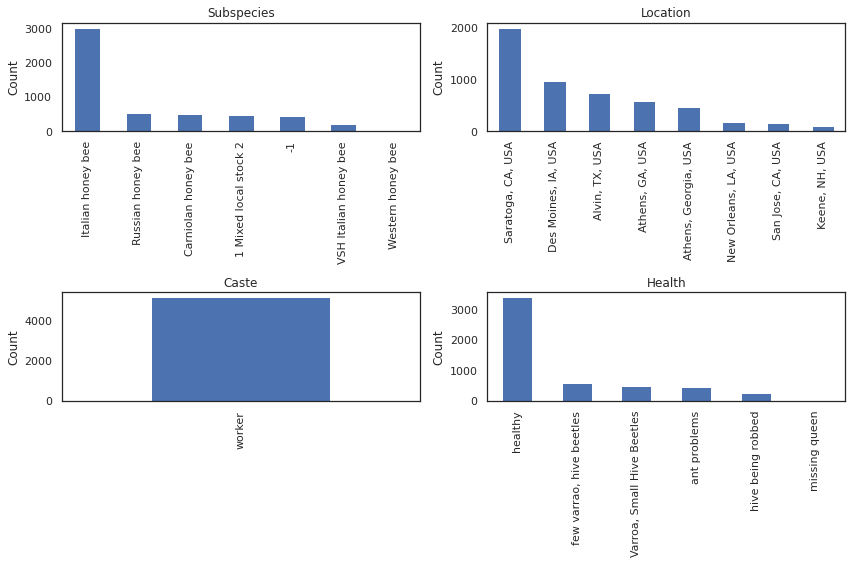

In [0]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

bees.subspecies.value_counts().plot(kind='bar',ax=ax[0, 0])
ax[0,0].set_ylabel('Count')
ax[0,0].set_title('Subspecies')

bees.location.value_counts().plot(kind='bar', ax=ax[0, 1])
ax[0,1].set_title('Location')
ax[0,1].set_ylabel('Count')

bees.caste.value_counts().plot(kind='bar', ax=ax[1, 0])
ax[1,0].set_title('Caste')
ax[1,0].set_ylabel('Count')

bees.health.value_counts().plot(kind='bar', ax=ax[1,1])
ax[1,1].set_title('Health')
ax[1,1].set_ylabel('Count')

f.subplots_adjust(hspace=0.7)
f.tight_layout()
plt.show()

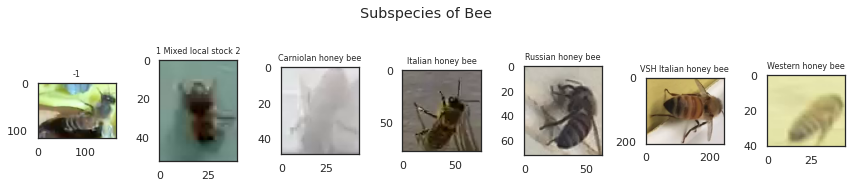

In [0]:
subspecies = bees['subspecies'].cat.categories
f, ax = plt.subplots(nrows=1,ncols=subspecies.size, figsize=(12,3))
i=0
# Draw the first found bee of given subpecies
for s in subspecies:
    if s == 'healthy': continue
    file=img_folder + bees[bees['subspecies']==s].iloc[0]['file']
    im=imageio.imread(file)
    ax[i].imshow(im, resample=True)
    ax[i].set_title(s, fontsize=8)
    i+=1
    
plt.suptitle("Subspecies of Bee")
plt.tight_layout()
plt.show()

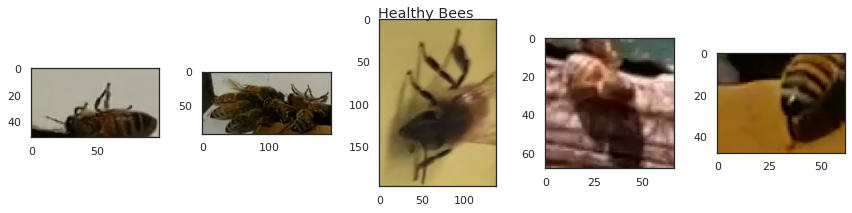

In [0]:
ncols = 5
healthy = bees[bees['health'] == 'healthy'].sample(ncols)
f, ax = plt.subplots(nrows=1,ncols=ncols, figsize=(12,3))
for i in range(0,5): 
    file = img_folder + healthy.iloc[i]['file']
    ax[i].imshow(imageio.imread(file))

plt.suptitle("Healthy Bees")
plt.tight_layout()
plt.show()

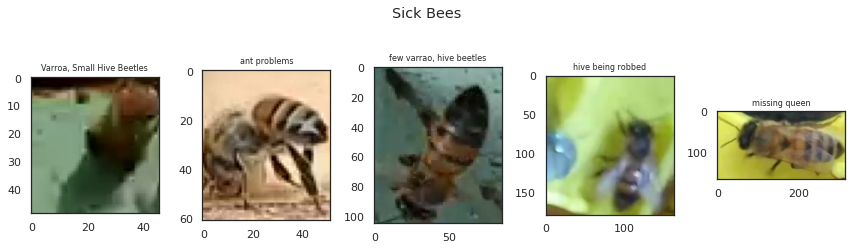

In [0]:
health_cats = bees['health'].cat.categories
f, ax = plt.subplots(1, health_cats.size-1, figsize=(12,4))
i=0
for c in health_cats:
    if c == 'healthy': continue
    bee = bees[bees['health'] == c].sample(1).iloc[0]
    ax[i].imshow(imageio.imread(img_folder + bee['file']))
    ax[i].set_title(bee['health'], fontsize=8)
    i += 1    
plt.suptitle("Sick Bees")    
plt.tight_layout()
plt.show()

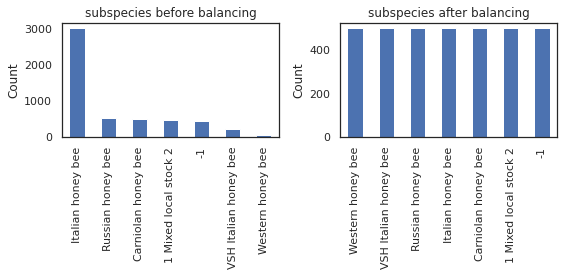

In [0]:
def split_balance(bees, field_name):
    train_bees, test_bees = train_test_split(bees, random_state=24)
    train_bees, val_bees = train_test_split(train_bees, test_size=0.1, random_state=24)
    ncat_bal = int(len(train_bees)/train_bees[field_name].cat.categories.size)
    train_bees_bal = train_bees.groupby(field_name, as_index=False).apply(lambda g:  g.sample(ncat_bal, replace=True)).reset_index(drop=True)
    return(train_bees_bal, val_bees, test_bees)    
def plot_balanced(train_bees, train_bees_bal, field_name):
    f, axs = plt.subplots(1,2, figsize=(8,4))


    ax = train_bees[field_name].value_counts().plot(kind='bar', ax=axs[0])
    ax.set_title('%s before balancing' % field_name)
    ax.set_ylabel('Count')
    
    ax = train_bees_bal[field_name].value_counts().plot(kind='bar', ax=axs[1])
    ax.set_title('%s after balancing' % field_name)
    ax.set_ylabel('Count')

    plt.tight_layout()
    plt.show()

# Split/balance and plot the result
train_bees_bal, val_bees, test_bees = split_balance(bees, 'subspecies')
plot_balanced(bees, train_bees_bal, 'subspecies')

# Will use balanced dataset as main
train_bees = train_bees_bal

In [0]:
def prepare2train(train_bees, val_bees, test_bees, field_name):

    # Train data
    train_X = np.stack(train_bees['file'].apply(read_img))
    train_y  = pd.get_dummies(train_bees[field_name], drop_first=False)

    val_X = np.stack(val_bees['file'].apply(read_img))
    val_y = pd.get_dummies(val_bees[field_name], drop_first=False)

    # Test data
    test_X = np.stack(test_bees['file'].apply(read_img))
    #test_y = to_categorical(test_bees[field_name].values)
    test_y = pd.get_dummies(test_bees[field_name], drop_first=False)

    # Data augmentation - a little bit rotate, zoom and shift input images.
    generator = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0.2, # Randomly zoom image 
            width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=True)
    generator.fit(train_X)
    return (generator, train_X, val_X, test_X, train_y, val_y, test_y)

#train_bees['subspecies'].cat.values[:-100]
# Call image preparation and one hot encoding
generator, train_X, val_X, test_X, train_y, val_y, test_y = prepare2train(train_bees, val_bees, test_bees, 'subspecies')

In [0]:
def prepare2train(train_bees, val_bees, test_bees, field_name):
    """
    Load images for features, drop other columns
    One hot encode for label, drop other columns
    @return: image generator, train images, validation images, test images, train labels, validation labels, test labels
    """
    # Bees already splitted to train, validation and test
    # Load and transform images to have equal width/height/channels. 
    # read_img function is defined in the beginning to use in both health and subspecies. 
    # Use np.stack to get NumPy array for CNN input

    # Train data
    train_X = np.stack(train_bees['file'].apply(read_img))
    #train_y = to_categorical(train_bees[field_name].values)
    train_y  = pd.get_dummies(train_bees[field_name], drop_first=False)

    # Validation during training data to calc val_loss metric
    val_X = np.stack(val_bees['file'].apply(read_img))
    #val_y = to_categorical(val_bees[field_name].values)
    val_y = pd.get_dummies(val_bees[field_name], drop_first=False)

    # Test data
    test_X = np.stack(test_bees['file'].apply(read_img))
    #test_y = to_categorical(test_bees[field_name].values)
    test_y = pd.get_dummies(test_bees[field_name], drop_first=False)

    # Data augmentation - a little bit rotate, zoom and shift input images.
    generator = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0.1, # Randomly zoom image 
            width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=True)
    generator.fit(train_X)
    return (generator, train_X, val_X, test_X, train_y, val_y, test_y)

#train_bees['subspecies'].cat.values[:-100]
# Call image preparation and one hot encoding
generator, train_X, val_X, test_X, train_y, val_y, test_y = prepare2train(train_bees, val_bees, test_bees, 'subspecies')

In [0]:
earlystopper1 = EarlyStopping(monitor='loss', patience=10, verbose=1)

# Save the best model during the traning
checkpointer1 = ModelCheckpoint('best_model1.h5'
                                ,monitor='val_acc'
                                ,verbose=1
                                ,save_best_only=True
                                ,save_weights_only=True)
# Build CNN model
model1=Sequential()
model1.add(Conv2D(6, kernel_size=3, input_shape=(img_width, img_height,3), activation='relu', padding='same'))
model1.add(MaxPool2D(2))
model1.add(Conv2D(12, kernel_size=3, activation='relu', padding='same'))
model1.add(Flatten())
model1.add(Dense(train_y.columns.size, activation='softmax'))
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
training1 = model1.fit_generator(generator.flow(train_X,train_y, batch_size=60)
                        ,epochs=30
                        ,validation_data=[val_X, val_y]
                        ,steps_per_epoch=50
                        ,callbacks=[earlystopper1, checkpointer1])
# Get the best saved weights
model1.load_weights('best_model1.h5')

Epoch 1/30
50/50 [==============================] - 15s 290ms/step - loss: 1.5464 - accuracy: 0.4158 - val_loss: 1.0208 - val_accuracy: 0.5412
Epoch 2/30


/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


50/50 [==============================] - 14s 279ms/step - loss: 0.7151 - accuracy: 0.7737 - val_loss: 0.7298 - val_accuracy: 0.7139
Epoch 3/30
50/50 [==============================] - 13s 267ms/step - loss: 0.4880 - accuracy: 0.8406 - val_loss: 0.7176 - val_accuracy: 0.7191
Epoch 4/30
50/50 [==============================] - 14s 279ms/step - loss: 0.4363 - accuracy: 0.8534 - val_loss: 0.8262 - val_accuracy: 0.6495
Epoch 5/30
50/50 [==============================] - 14s 275ms/step - loss: 0.3684 - accuracy: 0.8797 - val_loss: 0.5164 - val_accuracy: 0.7809
Epoch 6/30
50/50 [==============================] - 14s 281ms/step - loss: 0.3708 - accuracy: 0.8805 - val_loss: 0.8365 - val_accuracy: 0.6624
Epoch 7/30
50/50 [==============================] - 14s 272ms/step - loss: 0.3478 - accuracy: 0.8842 - val_loss: 0.6311 - val_accuracy: 0.7294
Epoch 8/30
50/50 [==============================] - 14s 278ms/step - loss: 0.3184 - accuracy: 0.8810 - val_loss: 0.6758 - val_accuracy: 0.7216
Epoch 9/30

OSError: Unable to open file (unable to open file: name = 'best_model1.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

VALIDATION ACCURACY- 0.8273

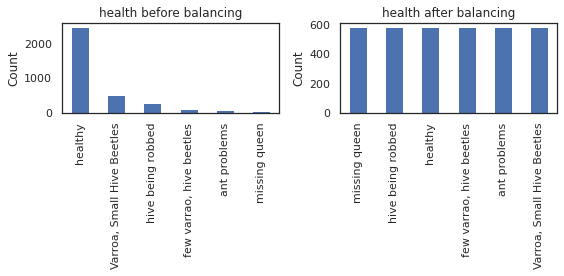

In [0]:
train_bees_bal, val_bees, test_bees = split_balance(bees, 'health')
plot_balanced(train_bees, train_bees_bal, 'health')

# Will use balanced dataset as main
train_bees_bal = train_bees

In [0]:
generator, train_X, val_X, test_X, train_y, val_y, test_y = prepare2train(train_bees, val_bees, test_bees, 'health')

In [0]:
earlystopper2 = EarlyStopping(monitor='val_acc', patience=10, verbose=1)

# Save the best model during the traning
checkpointer2 = ModelCheckpoint('best_model2.h5'
                                ,monitor='val_acc'
                                ,verbose=1
                                ,save_best_only=True
                                ,save_weights_only=True)
# Build CNN model
model2=Sequential()
model2.add(Conv2D(5, kernel_size=3, input_shape=(img_width, img_height,3), activation='relu', padding='same'))
model2.add(MaxPool2D(2))
model2.add(Conv2D(10, kernel_size=3, activation='relu', padding='same'))
model2.add(Flatten())
model2.add(Dense(train_y.columns.size, activation='softmax'))
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
training2 = model2.fit_generator(generator.flow(train_X,train_y, batch_size=60)
                        ,epochs=20
                        ,validation_data=[val_X, val_y]
                        ,steps_per_epoch=50
                        ,callbacks=[earlystopper2, checkpointer2])
# Get the best saved weights
model2.load_weights('best_model2.h5')

Epoch 1/20
50/50 [==============================] - 14s 274ms/step - loss: 1.0333 - accuracy: 0.6982 - val_loss: 1.3390 - val_accuracy: 0.5722
Epoch 2/20
 1/50 [..............................] - ETA: 9s - loss: 0.8606 - accuracy: 0.7000

/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


50/50 [==============================] - 14s 273ms/step - loss: 0.8120 - accuracy: 0.7356 - val_loss: 1.1880 - val_accuracy: 0.6031
Epoch 3/20
50/50 [==============================] - 13s 269ms/step - loss: 0.7489 - accuracy: 0.7363 - val_loss: 1.1861 - val_accuracy: 0.5799
Epoch 4/20
50/50 [==============================] - 14s 272ms/step - loss: 0.6416 - accuracy: 0.7707 - val_loss: 1.0971 - val_accuracy: 0.5773
Epoch 5/20
50/50 [==============================] - 13s 262ms/step - loss: 0.5130 - accuracy: 0.8302 - val_loss: 0.8713 - val_accuracy: 0.6649
Epoch 6/20
50/50 [==============================] - 13s 270ms/step - loss: 0.4765 - accuracy: 0.8523 - val_loss: 0.7937 - val_accuracy: 0.7191
Epoch 7/20
50/50 [==============================] - 14s 276ms/step - loss: 0.4240 - accuracy: 0.8639 - val_loss: 0.7913 - val_accuracy: 0.6985
Epoch 8/20
50/50 [==============================] - 13s 265ms/step - loss: 0.3839 - accuracy: 0.8710 - val_loss: 0.8315 - val_accuracy: 0.7294
Epoch 9/20

OSError: Unable to open file (unable to open file: name = 'best_model2.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

VALIDATION ACCURACY- 0.8196

---

